**Generating synthetic faces  using Deep Convolutional GAN**

100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


Starting Training Loop...
[0/20][0/391] Loss_D: 1.3773 Loss_G: 1.5284 D(x): 0.4841 D(G(z)): 0.4655 / 0.2231
[0/20][100/391] Loss_D: 0.5037 Loss_G: 3.9628 D(x): 0.9063 D(G(z)): 0.3040 / 0.0237
[0/20][200/391] Loss_D: 0.4105 Loss_G: 2.8796 D(x): 0.8044 D(G(z)): 0.1460 / 0.0678
[0/20][300/391] Loss_D: 0.5780 Loss_G: 4.2189 D(x): 0.8187 D(G(z)): 0.2759 / 0.0200
[1/20][0/391] Loss_D: 0.5213 Loss_G: 4.2779 D(x): 0.8618 D(G(z)): 0.2670 / 0.0262
[1/20][100/391] Loss_D: 0.3748 Loss_G: 3.9253 D(x): 0.8673 D(G(z)): 0.1810 / 0.0308
[1/20][200/391] Loss_D: 0.5761 Loss_G: 2.4893 D(x): 0.6618 D(G(z)): 0.0640 / 0.1153
[1/20][300/391] Loss_D: 1.0280 Loss_G: 4.5732 D(x): 0.9111 D(G(z)): 0.5431 / 0.0205
[2/20][0/391] Loss_D: 0.6700 Loss_G: 3.1343 D(x): 0.8417 D(G(z)): 0.3384 / 0.0624
[2/20][100/391] Loss_D: 0.9073 Loss_G: 4.0656 D(x): 0.7941 D(G(z)): 0.3976 / 0.0309
[2/20][200/391] Loss_D: 0.4243 Loss_G: 3.1253 D(x): 0.7956 D(G(z)): 0.1426 / 0.0638
[2/20][300/391] Loss_D: 0.5716 Loss_G: 2.7374 D(x): 0.78

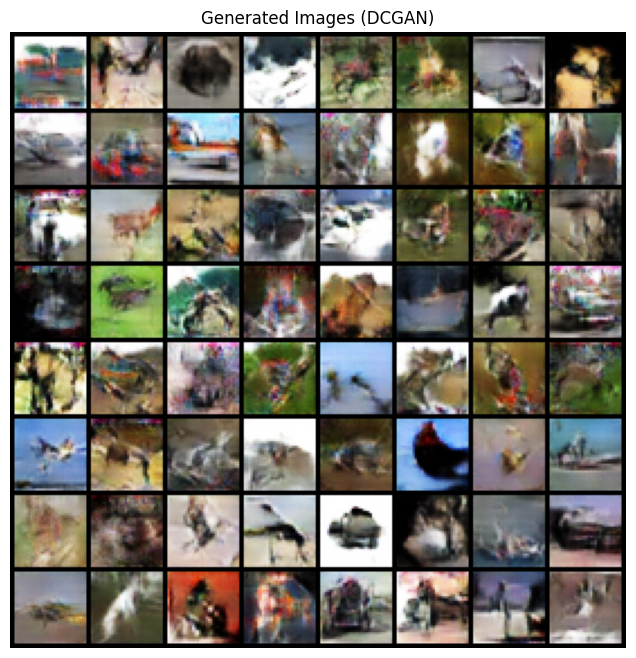

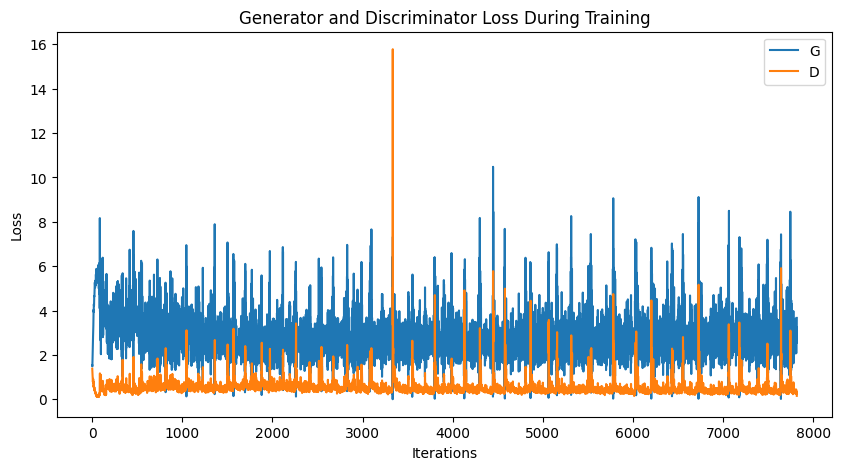

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import os

# Hyperparameters
image_size = 32      # CIFAR-10 images are 32x32
batch_size = 128
nz = 100             # Size of z latent vector (i.e. size of generator input)
ngf = 64             # Size of feature maps in generator
ndf = 64             # Size of feature maps in discriminator
num_epochs = 20
lr = 0.0002
beta1 = 0.5          # Beta1 hyperparam for Adam optimizers
nc = 3               # Number of channels in the training images. For color images this is 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading (CIFAR-10)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z latent vector
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),      # 8x8 -> 16x16
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),           # 16x16 -> 32x32
            nn.Tanh()  # Output: (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),      # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # 16x16 -> 8x8
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # 8x8 -> 4x4
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),   # 4x4 -> 1x1
            nn.Sigmoid()  # Output: 1
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # Save generated images for each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(make_grid(fake, padding=2, normalize=True))

    # Optionally save images to disk
    save_image(fake, f'generated_faces_epoch_{epoch+1}.png', nrow=8, normalize=True)

# Plot some generated images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images (DCGAN)")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

# Plot loss curves
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Generating synthetic faces with long hair using Conditional GAN**

100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


Starting Training Loop...
[0/10][0/391] Loss_D: 1.3913 Loss_G: 1.5409 D(x): 0.5791 D(G(z)): 0.5577 / 0.2232
[0/10][100/391] Loss_D: 1.0687 Loss_G: 1.7088 D(x): 0.5642 D(G(z)): 0.3115 / 0.1845
[0/10][200/391] Loss_D: 0.7523 Loss_G: 2.4654 D(x): 0.6978 D(G(z)): 0.2953 / 0.0896
[0/10][300/391] Loss_D: 0.5753 Loss_G: 2.9038 D(x): 0.7928 D(G(z)): 0.2658 / 0.0600
[1/10][0/391] Loss_D: 0.8397 Loss_G: 1.8403 D(x): 0.5813 D(G(z)): 0.1450 / 0.1781
[1/10][100/391] Loss_D: 0.8045 Loss_G: 2.2561 D(x): 0.6517 D(G(z)): 0.2273 / 0.1104
[1/10][200/391] Loss_D: 0.9834 Loss_G: 4.0666 D(x): 0.7674 D(G(z)): 0.4700 / 0.0221
[1/10][300/391] Loss_D: 0.8175 Loss_G: 2.2293 D(x): 0.6847 D(G(z)): 0.2756 / 0.1300
[2/10][0/391] Loss_D: 0.7597 Loss_G: 2.0228 D(x): 0.6326 D(G(z)): 0.1850 / 0.1476
[2/10][100/391] Loss_D: 0.5255 Loss_G: 2.3543 D(x): 0.7618 D(G(z)): 0.1763 / 0.1050
[2/10][200/391] Loss_D: 0.6745 Loss_G: 2.0697 D(x): 0.7008 D(G(z)): 0.1971 / 0.1444
[2/10][300/391] Loss_D: 0.7215 Loss_G: 3.9915 D(x): 0.88

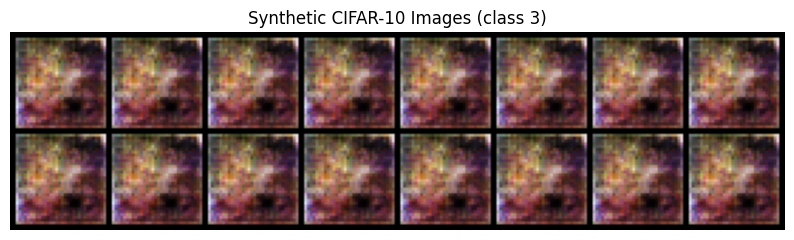

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
image_size = 32
batch_size = 128
nz = 100
ngf = 64
ndf = 64
num_epochs = 10
lr = 0.0002
beta1 = 0.5
nc = 3
num_classes = 10  # CIFAR-10 has 10 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading (CIFAR-10)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Conditional Generator and Discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz*2, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat([noise, label_input], 1)
        x = x.unsqueeze(2).unsqueeze(3)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, image_size*image_size)
        self.main = nn.Sequential(
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels).view(-1, 1, image_size, image_size)
        x = torch.cat([img, label_input], 1)
        return self.main(x).view(-1, 1).squeeze(1)

# Initialize models, loss, optimizers
netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        b_size = imgs.size(0)

        # Train Discriminator
        netD.zero_grad()
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(imgs, labels)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake images
        noise = torch.randn(b_size, nz, device=device)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device)
        fake_imgs = netG(noise, fake_labels)
        label.fill_(fake_label)
        output = netD(fake_imgs.detach(), fake_labels)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_imgs, fake_labels)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # Save generated images for each epoch (fixed batch of random classes)
    fixed_noise = torch.randn(16, nz, device=device)
    fixed_labels = torch.randint(0, num_classes, (16,), dtype=torch.long, device=device)
    with torch.no_grad():
        fake = netG(fixed_noise, fixed_labels).detach().cpu()
    save_image(fake, f'cgan_cifar10_epoch_{epoch+1}.png', nrow=8, normalize=True)

# Generate and Show Images for a Specific Class (e.g., class 3)
netG.eval()
with torch.no_grad():
    z = torch.randn(16, nz, device=device)
    class_label = 3  # Change this to any class (0-9)
    cond_labels = torch.full((16,), class_label, dtype=torch.long, device=device)
    fake_imgs = netG(z, cond_labels).cpu()
    grid = make_grid(fake_imgs, nrow=8, normalize=True)
    plt.figure(figsize=(10,5))
    plt.axis("off")
    plt.title(f"Synthetic CIFAR-10 Images (class {class_label})")
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()

**Generating painted form of faces using CycleGAN**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.33G/1.33G [00:10<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soumikrakshit/anime-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/anime-faces


In [15]:
import os
import shutil

celeba_img_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
os.makedirs('data/faces/class_0', exist_ok=True)

count = 0
for fname in os.listdir(celeba_img_dir):
    src = os.path.join(celeba_img_dir, fname)
    dst = f'data/faces/class_0/{fname}'
    if os.path.isfile(src) and fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.copy(src, dst)
        count += 1
    if count >= 500:
        break

print("Copied", count, "real face images.")

Copied 500 real face images.


In [20]:
import os
import shutil

anime_img_dir = "/kaggle/input/anime-faces/data"
os.makedirs('data/painted_faces/class_0', exist_ok=True)

count = 0
for fname in os.listdir(anime_img_dir):
    src = os.path.join(anime_img_dir, fname)
    dst = f'data/painted_faces/class_0/{fname}'
    if os.path.isfile(src) and fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.copy(src, dst)
        count += 1
    if count >= 500:
        break

print("Copied", count, "anime face images.")

Copied 500 anime face images.


[Epoch 0/5] [Batch 0] [D_A loss: 0.5748] [D_B loss: 0.5290] [G loss: 14.1968]
[Epoch 0/5] [Batch 50] [D_A loss: 0.2296] [D_B loss: 0.2053] [G loss: 6.5914]
[Epoch 0/5] [Batch 100] [D_A loss: 0.1517] [D_B loss: 0.1236] [G loss: 9.6867]


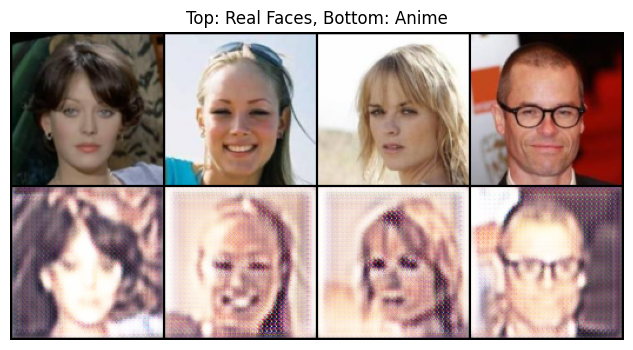

[Epoch 1/5] [Batch 0] [D_A loss: 0.2051] [D_B loss: 0.1861] [G loss: 4.8503]
[Epoch 1/5] [Batch 50] [D_A loss: 0.1382] [D_B loss: 0.1514] [G loss: 6.3245]
[Epoch 1/5] [Batch 100] [D_A loss: 0.1546] [D_B loss: 0.1256] [G loss: 4.8571]


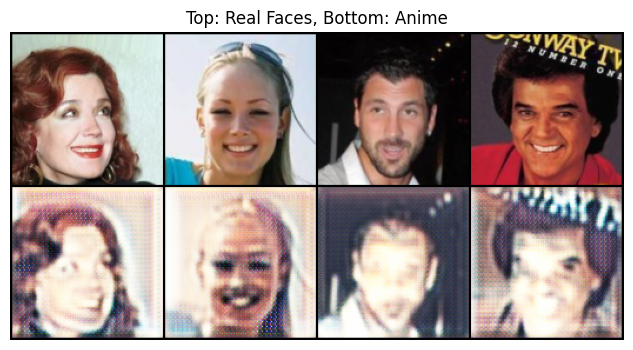

[Epoch 2/5] [Batch 0] [D_A loss: 0.0883] [D_B loss: 0.0910] [G loss: 5.5507]
[Epoch 2/5] [Batch 50] [D_A loss: 0.1165] [D_B loss: 0.1472] [G loss: 5.3862]
[Epoch 2/5] [Batch 100] [D_A loss: 0.1635] [D_B loss: 0.1321] [G loss: 5.7955]


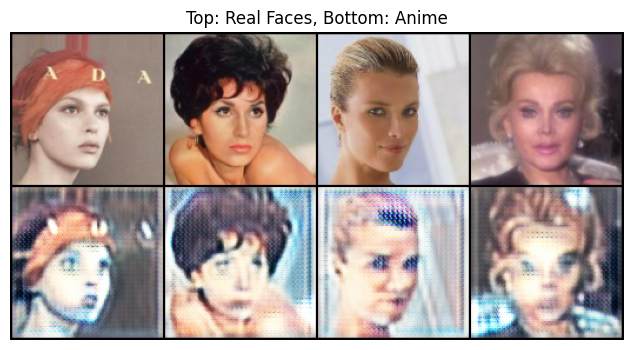

[Epoch 3/5] [Batch 0] [D_A loss: 0.1423] [D_B loss: 0.1102] [G loss: 5.1370]
[Epoch 3/5] [Batch 50] [D_A loss: 0.1856] [D_B loss: 0.1586] [G loss: 4.3515]
[Epoch 3/5] [Batch 100] [D_A loss: 0.1860] [D_B loss: 0.1486] [G loss: 4.5522]


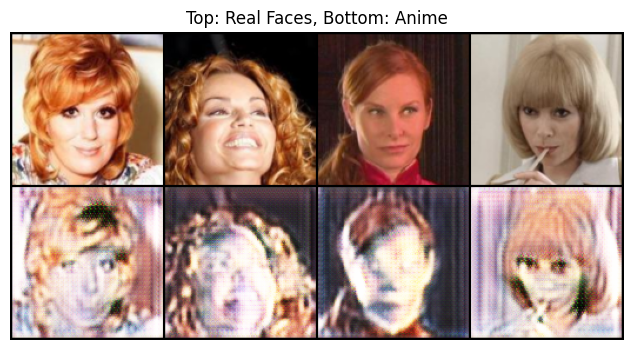

[Epoch 4/5] [Batch 0] [D_A loss: 0.1784] [D_B loss: 0.1671] [G loss: 5.5323]
[Epoch 4/5] [Batch 50] [D_A loss: 0.1510] [D_B loss: 0.4304] [G loss: 4.2869]
[Epoch 4/5] [Batch 100] [D_A loss: 0.1493] [D_B loss: 0.1001] [G loss: 5.2324]


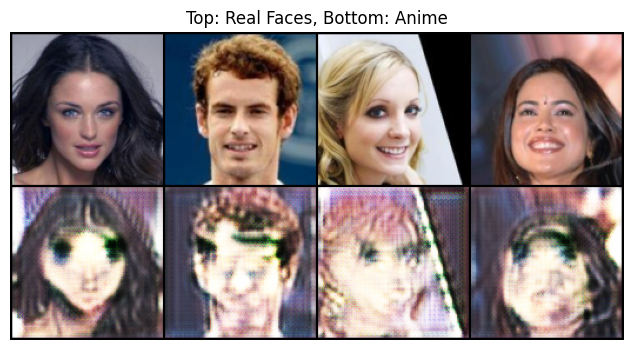

Training complete!


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import itertools
import matplotlib.pyplot as plt
import os

# --- Data Preparation ---
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

faces_dataset = datasets.ImageFolder('data/faces', transform=transform)
painted_dataset = datasets.ImageFolder('data/painted_faces', transform=transform)

faces_loader = DataLoader(faces_dataset, batch_size=4, shuffle=True, num_workers=2)
painted_loader = DataLoader(painted_dataset, batch_size=4, shuffle=True, num_workers=2)

# --- Model Components ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.InstanceNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=6):
        super().__init__()
        model = [
            nn.Conv2d(in_channels, 64, 7, 1, 3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, 2, 1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, 2, 1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        model += [
            nn.Conv2d(64, out_channels, 7, 1, 3),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_feat, out_feat, norm=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(in_channels, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, 1, 1)
        )
    def forward(self, x):
        return self.model(x)

# --- Initialize Models, Losses, Optimizers ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_AB = Generator().to(device)  # Face -> Anime
G_BA = Generator().to(device)  # Anime -> Face
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# --- Training Loop (with output shape fix) ---
def sample_images(batches_done):
    imgs = next(iter(faces_loader))[0][:4].to(device)
    G_AB.eval()
    with torch.no_grad():
        fake_paint = G_AB(imgs)
    imgs = torch.cat([imgs, fake_paint], 0)
    imgs = (imgs + 1) / 2
    grid = utils.make_grid(imgs, nrow=4)
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.title('Top: Real Faces, Bottom: Anime')
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.show()

epochs = 5  # For demo; use 100+ for real results
for epoch in range(epochs):
    for i, ((real_A, _), (real_B, _)) in enumerate(zip(faces_loader, painted_loader)):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        # Dynamically get the output shape of the discriminator
        with torch.no_grad():
            out_shape = D_A(real_A).shape
        valid = torch.ones(out_shape, device=device)
        fake = torch.zeros(out_shape, device=device)

        # Train Generators
        optimizer_G.zero_grad()
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * 0.5

        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * 10.0

        loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle + loss_identity
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator A
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        if i % 50 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}] "
                  f"[D_A loss: {loss_D_A.item():.4f}] [D_B loss: {loss_D_B.item():.4f}] "
                  f"[G loss: {loss_G.item():.4f}]")

    # Show sample images after each epoch
    sample_images(epoch)

print("Training complete!")